John Bean

John Neilson

CISC488 Intro to NLP Final Project

Tuning hyperparameters for COVID-19 NER tasks

**No need to run Data Processing as we have included the processed data**

# Imports

Enter a path to the directory where you include the files included with this submission.

In [1]:
# REPLACE THIS WITH YOUR PATH
path = '/content/drive/MyDrive/covid-nlp/'

Install necessary packages, and restart the session to allow them to be used.

In [2]:
import os
import json
from google.colab import drive
import srsly
import typer
import warnings
from pathlib import Path
import spacy
from spacy.tokens import DocBin
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Data Processing

### Pre-process dataset into json object

This codeblock is currently commented out as we have included the processed dataset in the code submission.

In [ ]:
'''
file_path = path + "CORD-NER-full.json"

# Each line of the json file is a different json object
with open(file_path, 'r') as file:
    lines = file.readlines()

for i in range(len(lines) - 1):
  lines[i] = lines[i].rstrip()+','

lines[0] = '[' + lines[0]
lines[-1] = lines[-1].rstrip() + ']'

#corrected_file_path = "/content/drive/MyDrive/S24/CISC488/CORD-NER-full-corrected.json"
corrected_file_path = "/content/drive/MyDrive/covid-nlp/CORD-NER-full-corrected.json"

with open(corrected_file_path, 'w') as file:
  for line in lines:
    file.write(line)
'''

### Trim dataset to allow for training on limited hardware

Load the dataset

In [ ]:
corrected_file_path = path + "CORD-NER-full-corrected.json"

with open(corrected_file_path, 'r') as file:
  data = json.load(file)

Trim the dataset because of hardware limitations

In [ ]:
trimmed_data = []

for instance in data:
  if instance["body"] != "" and len(instance["body"]) < 7000:
    new_inst = [instance["title"] + ' ' + instance["abstract"] + ' ' + instance["body"], {"entities": []}]
    for entity in instance["entities"]:
      new_inst[1]["entities"].append([entity["start"], entity["end"], entity["type"]])
    trimmed_data.append(new_inst)

Print the length of the trimmed dataset

In [ ]:
print(len(trimmed_data))

1019


Dump the trimmed dataset into file

In [ ]:
trimmed_file_path = '/content/drive/MyDrive/covid-nlp/trimmed_data.json'
with open(trimmed_file_path, 'w') as filehandle:
    json.dump(trimmed_data, filehandle)

Clearing large variables to free up memory for training, again, because of hardware limitations.

In [ ]:
'''
del data
file.close()
del new_inst
del instance
del entity
del file
del lines
del line
del file_path
del i
del corrected_file_path
del filehandle
del trimmed_file_path
import gc
gc.collect()
'''

NameError: name 'data' is not defined

#SpaCy Train Pipeline

### Setup spaCy config

Replace the path listed in this command with your path

In [3]:
!python -m spacy init fill-config /content/drive/MyDrive/covid-nlp/base_config.cfg /content/drive/MyDrive/covid-nlp/config.cfg

✔ Auto-filled config with all values
✔ Saved config
/content/drive/MyDrive/covid-nlp/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


### Prepping training and test data

Load and split data

In [4]:
processed_data = []
processed_data_path = path + 'trimmed_data.json'

with open(processed_data_path, 'r') as file:
  processed_data = json.load(file)
file.close()
del file
del processed_data_path

print(processed_data)

TRAIN_DATA = processed_data[:int(len(processed_data)*.7)]
VALID_DATA = processed_data[int(len(processed_data)*.7):]
del processed_data

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Converting data into spaCy binary

In [5]:
def convert(lang: str, TRAIN_DATA, output_path: Path):
    check = 0
    nlp = spacy.blank(lang)
    db = DocBin()
    for text, annot in TRAIN_DATA:
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label)
            if span is None:
                check = check + 1
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    db.to_disk(output_path)
    print('Skipped: ' + str(check))

In [6]:
convert_path= path + 'converted.spacy'
convert('en', TRAIN_DATA, convert_path)

Skipped: 4224


In [7]:
convert_path = path + 'converted_valid.spacey'
convert('en', VALID_DATA, convert_path)

Skipped: 3333


### Train spaCy model

**Before you run this model, you need to edit the config.cfg file and change `train` to your path to 'converted.spacy' and `dev` to your path to 'converted_valid.spacy'.**

This notebook walks through training and evaluating one model. For the other models, simply modify the learning rate and batch size in config.cfg

In [12]:
!python -m spacy train /content/drive/MyDrive/covid-nlp/config.cfg --output /content/drive/MyDrive/covid-nlp/output

ℹ Saving to output directory:
/content/drive/MyDrive/covid-nlp/output
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    698.91    0.00    0.00    0.00    0.00
  0     200       5214.47  39916.31   23.78   36.45   17.65    0.24
  0     400       7526.99  30483.77   38.67   56.60   29.37    0.39
  0     600      16393.66  27087.96   49.22   64.81   39.68    0.49
  1     800      21218.16  26611.02   50.97   59.34   44.67    0.51
  1    1000       9083.30  22355.34   54.18   69.23   44.51    0.54
  1    1200      18778.73  22810.23   55.04   68.14   46.16    0.55
  1    1400      16290.92  21842.44   56.84   62.55   52.08    0.5

# Test and score spaCy model

### Get some examples and set model path

In [17]:
trained_nlp_path = path + "output/model-best"
trained_nlp = spacy.load(trained_nlp_path)
text = "The Middle East respiratory syndrome coronavirus (MERS-CoV) is an emerging virus of great global public health concern [1, 2] . From its initial recognition in 2012 in Saudi Arabia [3] to August 2019, there have been 2,468 patients with confirmed MERS-CoV infection, including 850 deaths, reported to the World Health Organization (WHO) from 27 countries [4] . Dromedary camels are known to be the source of human infection [5] . The virus is enzootic in dromedaries in the Arabian Peninsula, the Middle East, many regions of Africa, as well as Pakistan and Bangladesh. Over 70% of the global population of infected dromedaries are found in Africa, including Morocco [6, 7] . Although travel-associated cases have been reported from several countries, zoonotic MERS cases have only been reported in the Arabian Peninsula and the Middle East [2] . The reasons for the apparent absence of zoonotic MERS in Africa in spite of exposure to virus-infected dromedaries is unclear, but likely because of several factors [2] . This may be owed to genetic and phenotypic differences in virus strains circulating in Africa [8] , behavioural factors relating patterns of exposure, or alternatively, that MERS is not being detected because of the assumption that zoonotic MERS does not occur in Africa which may lead to a lack of testing for MERS-CoV. Humans with regular contact with dromedaries in the Arabian Peninsula have higher seroprevalence to MERS-CoV than the general population [9] . Thus far, only a limited number of serological studies have been conducted in people with intense exposure to MERS-CoV-infected camels in Africa. Such studies are, however, important to better understand the geographic extent of MERS-CoV infection in human populations. Camel-exposed abattoir workers in Nigeria had no serological evidence of MERS-CoV infection despite intensive exposure to MERS-CoV infected camels [10] . Similarly, people in contact with camels in Kenya and Egypt had no serological evidence of MERS-CoV infection [11] [12] [13] . Another Kenyan study of 1,122 individuals without direct occupational exposure to dromedary camels found two individuals with low levels of neutralising antibody to MERS-CoV; to our knowledge, these are the only known instances of MERS-CoV seropositivity in humans in Africa prior to this study [14] . In Morocco, a recent study of MERS-CoV showed seroprevalence ranging from 48.3% to 100% and viral RNA shedding rates ranging from 0% to 7.6% among dromedaries [6] . Southern Morocco is the region of the country with the highest density of dromedary camels [15] . People living in this region share a close cultural and economic bond with dromedaries, and they are also consumers of dromedary milk, meat and other products. There are with many people having close and repetitive contact with dromedaries, including slaughterhouse workers, camel market workers and camel herders. Since there is no information on MERS-CoV infections in humans in Morocco, the aim of this study was to determine the MERS-CoV seroprevalence among a presumed high-risk population, people in close contact with dromedaries, that is to say, those living in camel herding areas, including individuals with occupational exposure to dromedaries. We adapted and used an existing investigation protocol for cross-sectional seroepidemiologic study of MERS-CoV infection in high-risk populations in contact with dromedary camels developed by WHO [16] . The WHO protocol was translated into French, questions were modified, deleted or added to make it more relevant to Morocco, and it was used to ascertain risks of exposure to dromedaries as well as dromedary products. The administrative regions of Guelmim-Oued Noun, La\u00e2youne-Sakia El Hamra and Dakhla-Oued Ed-Dahab were selected for study because 83.2% of all dromedary camels in Morocco are in these three regions [15] . The population of these regions was considered at high-risk of MERS-CoV infection because of direct or indirect contact with dromedaries, and for the study purposes, further divided into in three categories; camel herders and slaughterhouse workers, both with occupational exposure, and the general population, i.e. individuals living in high-risk areas who did not have direct occupational contact with dromedaries. Human blood sample collection was carried out over the 3 months from November 2017 through January 2018. A convenience sampling strategy was used to sample the different risk groups which led to blood samples being collected from 156 camel herders, 137 camel slaughterhouse (abattoir) workers and 186 individuals from the general population. Each participant provided signed informed consent and were administered a detailed questionnaire to elicit demographic information, as well as information about food habits, duration and type of exposure to camels and history of respiratory symptoms. For camel herders and abattoir workers, the use of personal protective equipment such as boots, coveralls, masks, gloves or coats, or other hygiene practices was also elicited. Two hundred age-stratified sera collected in 2017 from blood donors in Hong Kong aged 16 to 69 years with no known exposure to dromedary camels were used as controls. Human sera were tested for MERS-CoV IgG antibodies using a MERS-CoV S1 spike ELISA (EI 2604-9601 G kit, Euroimmun, L\u00fcbeck, Germany) according to the manufacturer's instructions, at the Medical Virology and BSL-3 Laboratory at Institut Pasteur du Maroc, Casablanca, Morocco. The extinction value of the calibrator included in the test defines the upper limit of the reference range in non-infected humans and this value was set as the cut-off. The ELISA was made semiquantitative by calculating the ratio of the extinction value of the serum sample over the extinction value of the calibrator. The manufacturer recommends cut-off ratios of < 0.8 be interpreted as negative, \u2265 0.8 and < 1.1 as borderline, and \u2265 1.1 as positive. Because subsequent publications suggested a lower ELISA cut-off of ratio \u2265 0.3 for screening purposes for the selection of sera to be confirmed by neutralisation tests, we have also included ELISA optical density (OD) ratios of \u2265 0.3 in our analysis [9] . All sera were also screened in triplicate in a MERS-CoV pseudoparticle neutralisation test (ppNT) as described previously [11] . All sera positive at a ppNT screening dilution of 1:10 were titrated to end-point in the ppNT assay, as well as in a plaque reduction neutralisation test (PRNT) conducted in BSL-3 containment. The endpoint for the ppNT assay was the highest serum dilution giving a \u2265 90% reduction in the luciferase signal compared with negative control. The end-point in the PRNT was the highest serum dilution that gave \u2265 50% (PRNT 50 ) or \u2265 90% (PRNT 90 ) reduction of virus plaques compared with control. The methods have been described elsewhere [11, 17] . Sera-positive at a titre of \u2265 1:20 in ppNT and \u2265 1:10 in PRNT 90 assays were regarded as positive. Sera-positive at a titre of \u2265 1:20 in ppNT and \u2265 1:10 in PRNT 50 , but negative in PRNT 90 assays were regarded as a borderline positive neutralisation result. All other sera were regarded as negative. Statistical significance of serological positivity by exposure group was analysed using the chi-squared test with Yates correction. Statistical significance was defined as p < 0.05.  Samples were collected from a total of 479 people, of whom 120 were female and 359 were male (  The direct and indirect exposure patterns to dromedaries and dromedary products (raw camel meat, camel urine or unpasteurised camel milk) of the study subjects are summarised in Table 1 . Consumption of raw camel meat and unpasteurized camel milk was not uncommon in all three groups, ranging between 32% and 81%, and 63% and 80%, respectively ( Table 1) . None of the participants had a history of severe pneumonia that required hospital admission and none of them had travelled outside of Morocco. Camel herders (n = 156) had been such for at least 1 year, travelling with nomadic dromedary herds for many months of the year with 95 (61%) and having contact with camels around their home the rest of the year. All herders had camels in their herds, but 5 (3%) also had sheep and goats within their herd. Their tasks while herding included cleaning and caring for the animals (n = 113; 72%), feeding, milking, marketing and other supplemental tasks (n = 43; 28%). Most herders reported contact with dromedary waste (n = 140; 90%), while some had contact with ill (n = 52; 33%) or dead (n = 21; 13%) dromedaries, and some directly handled dromedaries that died from illness (n = 19; 12%). Personal protective gear, e.g. boots, coverall, mask or coat, were used only by 4 (3%) of the herders. The slaughterhouse workers (n = 137) had worked in the dromedary slaughterhouse for at least 1 year. Their working hours were 5 to 7 hours per day, 6 days per week. They uniformly had occupational contact with camels at the slaughterhouse, but some (n = 28; 20%) also had dromedaries around the home (Table 1) . For 115 (84%), work included slaughtering, cleaning the slaughterhouse and storing the camel meat. The other 22 (16%) were not directly involved in slaughtering but involved in cleaning, transporting products and security. Personal protective gear, usually reported as boots"
doc = trained_nlp(text)

for ent in doc.ents:
    print (ent.text, ent.label_)

Middle East respiratory syndrome coronavirus CORONAVIRUS
MERS-CoV CORONAVIRUS
global public health CHEMICAL
2012 DATE
Saudi Arabia [3 GPE
August 2019 DATE
patients GROUP
MERS-CoV CORONAVIRUS
850 CARDINAL
deaths DISEASE_OR_SYNDROME
Dromedary WILDLIFE
camels WILDLIFE
human infection DISEASE_OR_SYNDROME
dromedaries WILDLIFE
Arabian Peninsula GENE_OR_GENOME
Africa LOC
Pakistan CHEMICAL
Bangladesh CHEMICAL
Africa LOC
MERS CORONAVIRUS
Arabian Peninsula GENE_OR_GENOME
Middle East [2 CORONAVIRUS
MERS CORONAVIRUS
Africa LOC
Africa LOC
behavioural factors GENE_OR_GENOME
MERS CORONAVIRUS
MERS CORONAVIRUS
Africa LOC
Humans EUKARYOTE
dromedaries WILDLIFE
Arabian Peninsula GENE_OR_GENOME
seroprevalence RESEARCH_ACTIVITY
MERS-CoV CORONAVIRUS
people ORGANISM
MERS-CoV CORONAVIRUS
camels WILDLIFE
Africa LOC
MERS-CoV CORONAVIRUS
human ORGANISM
Camel WILDLIFE
workers GROUP
Nigeria GPE
MERS-CoV CORONAVIRUS
MERS-CoV CORONAVIRUS
camels WILDLIFE
people ORGANISM
camels WILDLIFE
Kenya GPE
Egypt GPE
MERS-CoV COR

### Score model

In [18]:
from spacy.scorer import Scorer
from spacy.training import Example

In [19]:
nlp = spacy.load(trained_nlp_path)
examples = []
scorer = Scorer()
for text, annotations in VALID_DATA:
    doc = nlp.make_doc(text)
    example = Example.from_dict(doc, annotations)
    example.predicted = nlp(str(example.predicted))
    examples.append(example)
scores = scorer.score(examples)

### Save scores to json

In [20]:
#save_scores_path = path + 'batch500lr001.json'
#save_scores_path = path + 'batch1000lr01.json'
save_scores_path = path + 'batch1000lr001.json'
with open(save_scores_path, 'w+') as filehandle:
    json.dump(scores, filehandle)

In [21]:
filehandle.close()

### Read scores from json

In [22]:
#scores_path = path + 'batch500lr001.json'
#scores_path = path + 'batch1000lr01.json'
scores_path = path + "batch1000lr001.json"
with open(scores_path, 'r') as filehandle:
    scores = json.load(filehandle)

In [23]:
print(scores)

{'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'sents_p': None, 'sents_r': None, 'sents_f': None, 'tag_acc': None, 'pos_acc': None, 'morph_acc': None, 'morph_micro_p': None, 'morph_micro_r': None, 'morph_micro_f': None, 'morph_per_feat': None, 'dep_uas': None, 'dep_las': None, 'dep_las_per_type': None, 'ents_p': 0.703902065799541, 'ents_r': 0.619191840749657, 'ents_f': 0.6588351947998292, 'ents_per_type': {'CORONAVIRUS': {'p': 0.8508535489667565, 'r': 0.9465267366316842, 'f': 0.896143837236811}, 'CHEMICAL': {'p': 0.608559670781893, 'r': 0.5574487334137516, 'f': 0.5818840009443613}, 'GROUP': {'p': 0.93717277486911, 'r': 0.9040404040404041, 'f': 0.9203084832904885}, 'ORGANISM': {'p': 0.7625482625482626, 'r': 0.6677937447168216, 'f': 0.7120324470482199}, 'GENE_OR_GENOME': {'p': 0.48828125, 'r': 0.3656857683703321, 'f': 0.41818360720259773}, 'CARDINAL': {'p': 0.8067510548523207, 'r': 0.8067510548523207, 'f': 0.8067510548523207}, 'DISEASE_OR_SYNDROME': {'p': 0.6980609418

#Visualize scores

In [24]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
df = pd.DataFrame(scores["ents_per_type"]).transpose()
df_sorted = df.sort_index()

### Percision

<ipython-input-26-219cbdb32708>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=first_half.index, y=first_half['p'], palette='viridis')


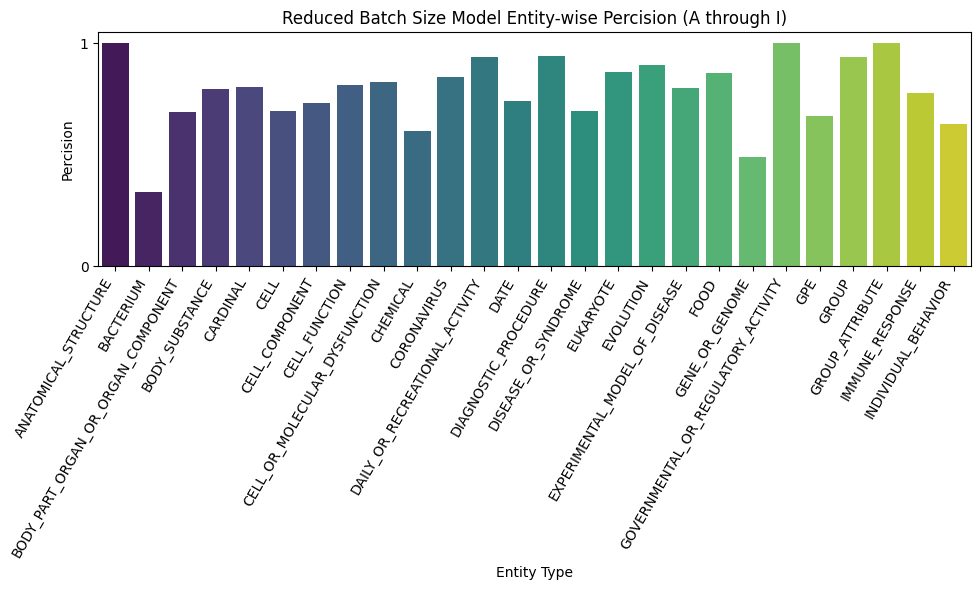

<ipython-input-26-219cbdb32708>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=second_half.index, y=second_half['p'], palette='viridis')


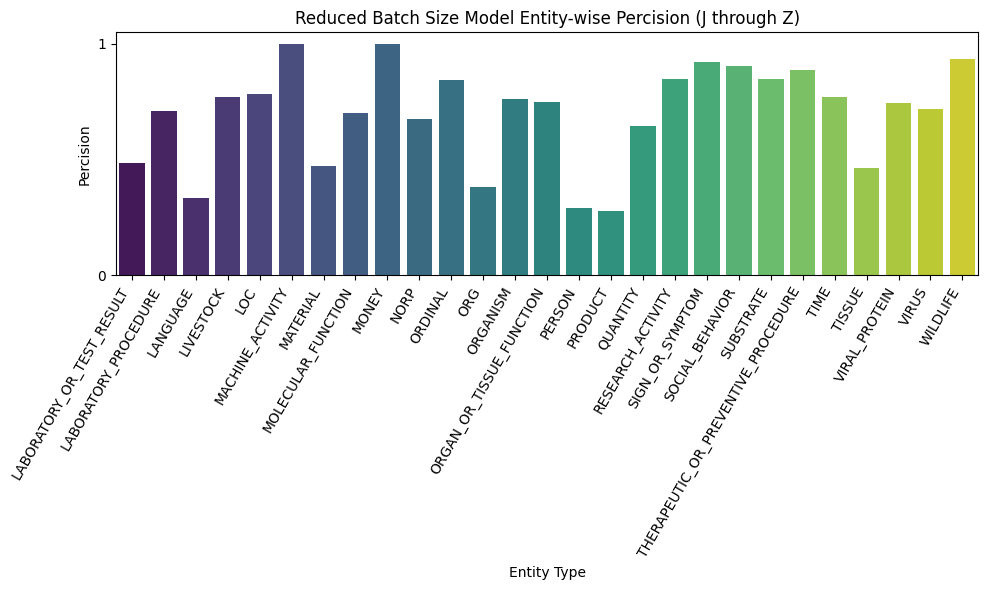

In [26]:
df_filtered = df_sorted[df_sorted['p'] != 0]

# Split the DataFrame into two halves
half_index = len(df_filtered) // 2
first_half = df_filtered.iloc[:half_index]
second_half = df_filtered.iloc[half_index:]

# Plotting the first half
plt.figure(figsize=(10, 6))
sns.barplot(x=first_half.index, y=first_half['p'], palette='viridis')
plt.title('Reduced Batch Size Model Entity-wise Percision (A through I)')
plt.xlabel('Entity Type')
plt.ylabel('Percision')
plt.xticks(rotation=60, ha='right')  # Rotate x-axis labels by 60 degrees and adjust alignment
plt.yticks(range(0, 2))  # Set y-tick positions
plt.subplots_adjust(bottom=0.2)  # Adjust spacing at the bottom
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Plotting the second half
plt.figure(figsize=(10, 6))
sns.barplot(x=second_half.index, y=second_half['p'], palette='viridis')
plt.title('Reduced Batch Size Model Entity-wise Percision (J through Z)')
plt.xlabel('Entity Type')
plt.ylabel('Percision')
plt.xticks(rotation=60, ha='right')  # Rotate x-axis labels by 60 degrees and adjust alignment
plt.yticks(range(0, 2))  # Set y-tick positions
plt.subplots_adjust(bottom=0.2)  # Adjust spacing at the bottom
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

### Recall

<ipython-input-27-baa2f54e055c>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=first_half.index, y=first_half['r'], palette='viridis')


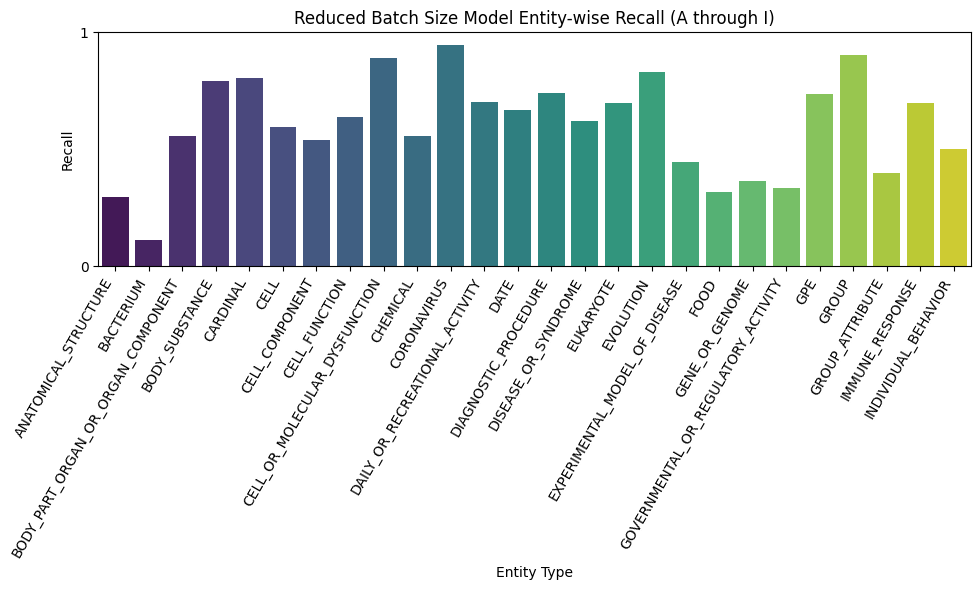

<ipython-input-27-baa2f54e055c>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=second_half.index, y=second_half['r'], palette='viridis')


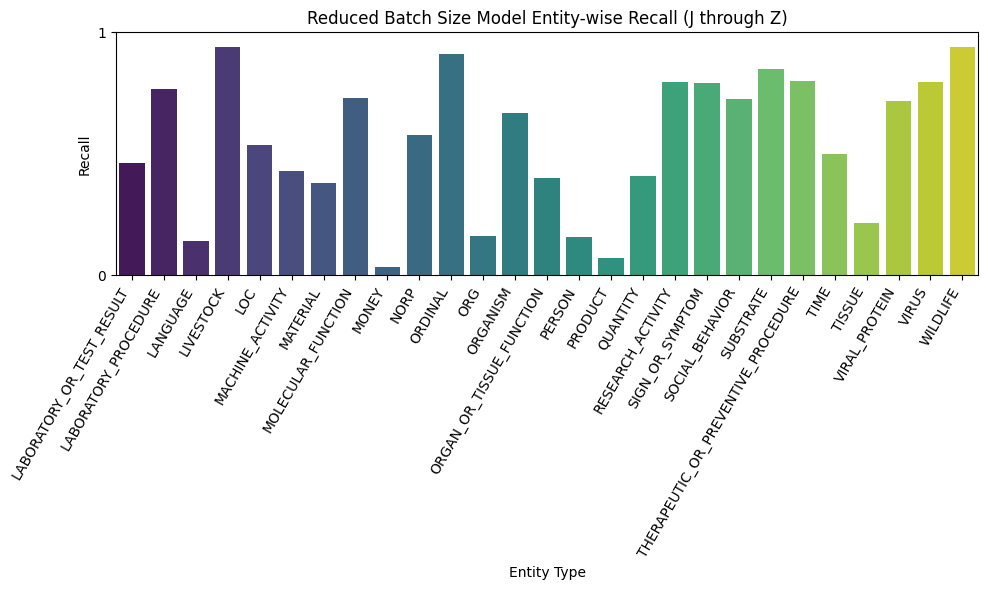

In [27]:
df_filtered = df_sorted[df_sorted['r'] != 0]

# Split the DataFrame into two halves
half_index = len(df_filtered) // 2
first_half = df_filtered.iloc[:half_index]
second_half = df_filtered.iloc[half_index:]


# Plotting the first half
plt.figure(figsize=(10, 6))
sns.barplot(x=first_half.index, y=first_half['r'], palette='viridis')
plt.title('Reduced Batch Size Model Entity-wise Recall (A through I)')
plt.xlabel('Entity Type')
plt.ylabel('Recall')
plt.xticks(rotation=60, ha='right')  # Rotate x-axis labels by 60 degrees and adjust alignment
plt.yticks(range(0, 2))  # Set y-tick positions
plt.subplots_adjust(bottom=0.2)  # Adjust spacing at the bottom
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Plotting the second half
plt.figure(figsize=(10, 6))
sns.barplot(x=second_half.index, y=second_half['r'], palette='viridis')
plt.title('Reduced Batch Size Model Entity-wise Recall (J through Z)')
plt.xlabel('Entity Type')
plt.ylabel('Recall')
plt.xticks(rotation=60, ha='right')  # Rotate x-axis labels by 60 degrees and adjust alignment
plt.yticks(range(0, 2))  # Set y-tick positions
plt.subplots_adjust(bottom=0.2)  # Adjust spacing at the bottom
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


### F1 Score

<ipython-input-28-d123c0375369>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=first_half.index, y=first_half['r'], palette='viridis')


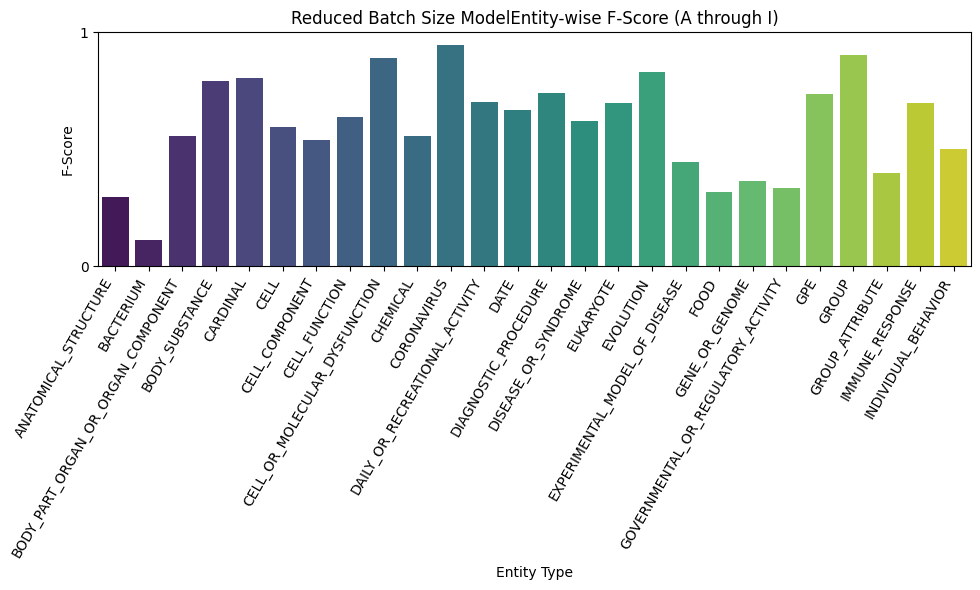

<ipython-input-28-d123c0375369>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=second_half.index, y=second_half['r'], palette='viridis')


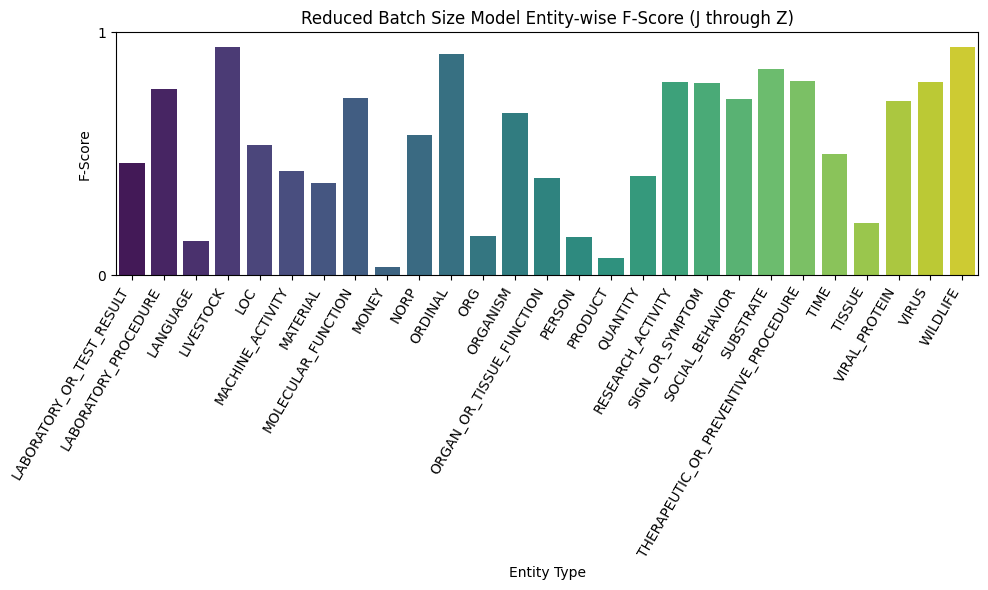

In [28]:
df_filtered = df_sorted[df_sorted['f'] != 0]

# Split the DataFrame into two halves
half_index = len(df_filtered) // 2
first_half = df_filtered.iloc[:half_index]
second_half = df_filtered.iloc[half_index:]


# Plotting the first half
plt.figure(figsize=(10, 6))
sns.barplot(x=first_half.index, y=first_half['r'], palette='viridis')
plt.title('Reduced Batch Size ModelEntity-wise F-Score (A through I)')
plt.xlabel('Entity Type')
plt.ylabel('F-Score')
plt.xticks(rotation=60, ha='right')  # Rotate x-axis labels by 60 degrees and adjust alignment
plt.yticks(range(0, 2))  # Set y-tick positions
plt.subplots_adjust(bottom=0.2)  # Adjust spacing at the bottom
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Plotting the second half
plt.figure(figsize=(10, 6))
sns.barplot(x=second_half.index, y=second_half['r'], palette='viridis')
plt.title('Reduced Batch Size Model Entity-wise F-Score (J through Z)')
plt.xlabel('Entity Type')
plt.ylabel('F-Score')
plt.xticks(rotation=60, ha='right')  # Rotate x-axis labels by 60 degrees and adjust alignment
plt.yticks(range(0, 2))  # Set y-tick positions
plt.subplots_adjust(bottom=0.2)  # Adjust spacing at the bottom
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

### Getting mean, median, and mode of percision, recall, and f-score

In [29]:
p_df = df_sorted[df_sorted['p'] != 0]

mean = p_df.mean()
median = p_df.median()
mode = p_df.mode().iloc[0]

print(mean)
print(median)
print(mode)

p    0.742921
r    0.577249
f    0.626582
dtype: float64
p    0.771772
r    0.620308
f    0.656891
dtype: float64
p    1.0
r    0.4
f    0.5
Name: 0, dtype: float64


### Plotting metrics for all three models

Values in Mean, Median, Mode are saved values from our 3 models.

In [30]:
# initialize list of lists

metrics = {
    'Model': ['Control', 'Control', 'Control', 'Increased LR', 'Increased LR', 'Increased LR', 'Decreased Batch', 'Decreased Batch', 'Decreased Batch'],
    'Metric': ['Precision', 'Recall', 'F-score', 'Precision', 'Recall', 'F-score', 'Precision', 'Recall', 'F-score'],
    'Mean': [0.742921, 0.577249, 0.626582, 0.720461, 0.516043, 0.567693, 0.742921, 0.577249, 0.626582],
    'Median': [0.771772, 0.620308, 0.656891, 0.762027, 0.567010, 0.625661, 0.7717772, 0.620308, 0.656891],
    'Mode': [1.0, 0.4, 0.5, 1.0, 0.02439, 0.4, 1.0, 0.4, 0.5]
}


# Create the pandas DataFrame
df = pd.DataFrame(metrics)

print(df)

             Model     Metric      Mean    Median     Mode
0          Control  Precision  0.742921  0.771772  1.00000
1          Control     Recall  0.577249  0.620308  0.40000
2          Control    F-score  0.626582  0.656891  0.50000
3     Increased LR  Precision  0.720461  0.762027  1.00000
4     Increased LR     Recall  0.516043  0.567010  0.02439
5     Increased LR    F-score  0.567693  0.625661  0.40000
6  Decreased Batch  Precision  0.742921  0.771777  1.00000
7  Decreased Batch     Recall  0.577249  0.620308  0.40000
8  Decreased Batch    F-score  0.626582  0.656891  0.50000


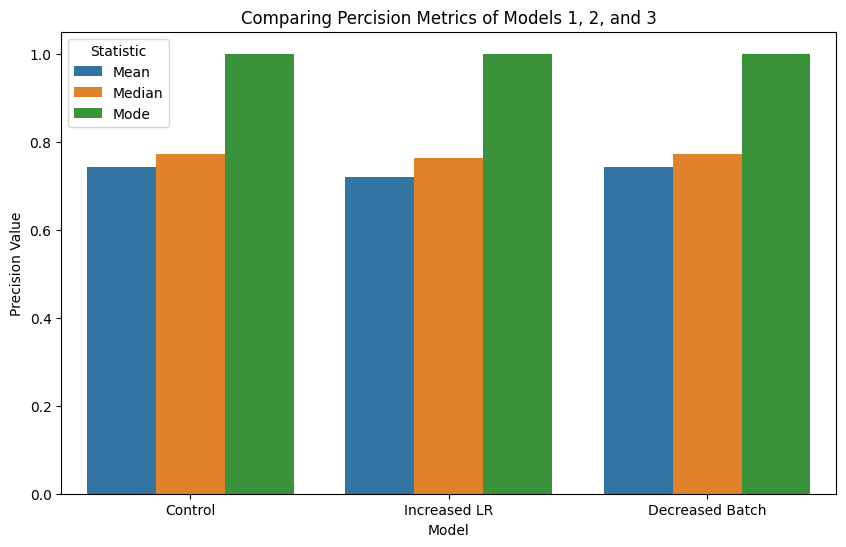

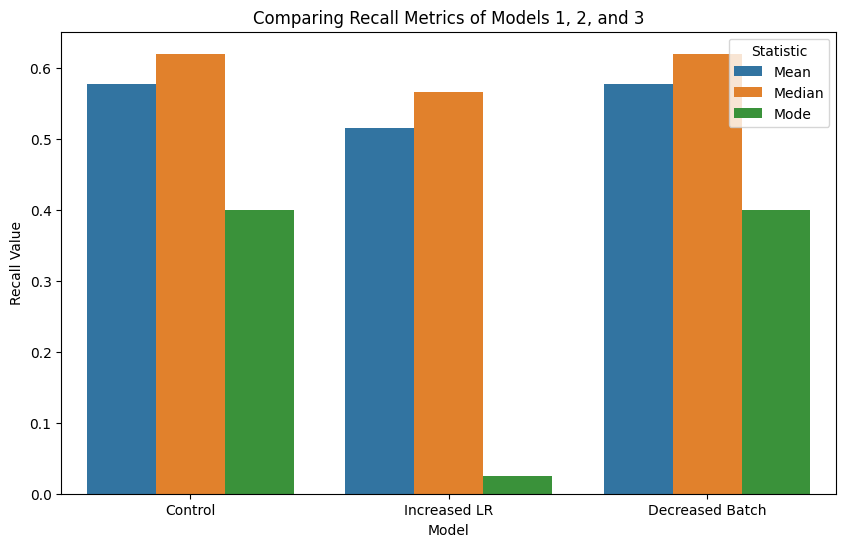

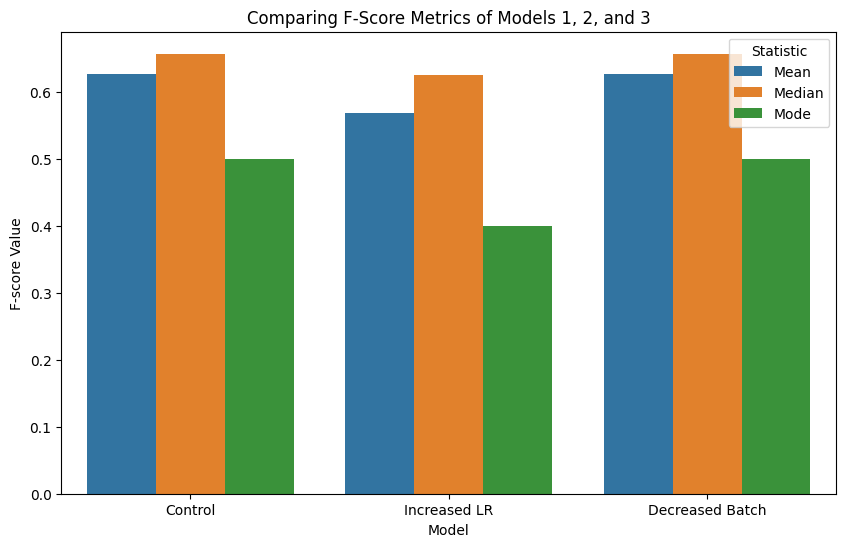

In [31]:
# Melt the DataFrame to long format for seaborn plotting
df_melted = pd.melt(df, id_vars=['Model', 'Metric'], var_name='Statistic', value_name='Value')

# Plot for Precision
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted[df_melted['Metric'] == 'Precision'], x='Model', y='Value', hue='Statistic')
plt.title('Comparing Percision Metrics of Models 1, 2, and 3')
plt.xlabel('Model')
plt.ylabel('Precision Value')
plt.legend(title='Statistic')
plt.show()

# Plot for Recall
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted[df_melted['Metric'] == 'Recall'], x='Model', y='Value', hue='Statistic')
plt.title('Comparing Recall Metrics of Models 1, 2, and 3')
plt.xlabel('Model')
plt.ylabel('Recall Value')
plt.legend(title='Statistic')
plt.show()

# Plot for F-score
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted[df_melted['Metric'] == 'F-score'], x='Model', y='Value', hue='Statistic')
plt.title('Comparing F-Score Metrics of Models 1, 2, and 3')
plt.xlabel('Model')
plt.ylabel('F-score Value')
plt.legend(title='Statistic')
plt.show()